In [0]:
# Notebook initialization with import of all required modules
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# PyDrive initialization
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation of required Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import re
import time
from datetime import datetime
import dateutil

from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics, preprocessing
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.simplefilter('ignore')


Ce notebook est la premère partie du projet 5 du parcours Data Scientist. 

Ce projet consiste en la clusterisation des clients d'un site d'e-commerce, Olist. En effet, segmenter les clients selon leur comportement d'achat et leurs données personnelles rend les campagnes de communication plus pertinentes et augmente ainsi leur efficacité. Cette première partie consiste donc en l'analyse des fichiers de la base de données fournie, afin d'en extraire les données pertinentes et utilisables pour nos modèles utilisées dans la seconde partie du projet.

<h3>Sommaire</h3>


1.   Description des fichiers de base
2.   Traitement des données et création du fichier de base d'application des modèles
3.   Traitement des données et création du fichier d'application des modèles avec métacatégories
4.   Analyse des variables finalement choisies



# Description des fichiers de base

In [0]:
# Data importation into the notebook, from Google Drive
link1 = "https://drive.google.com/open?id=1Sv40SVNbgxRX6TwjtfffUC88sdaXw6Du"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_customers_dataset.csv')
datacustomers = pd.read_csv('olist_customers_dataset.csv', sep=',')
print ("Customers Dataset : imported")

link1 = "https://drive.google.com/open?id=1BPc3th-yYVkfEQvrAG0dnnyLHkRJuaJs"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_geolocation_dataset.csv')
datageolocation = pd.read_csv('olist_geolocation_dataset.csv', sep=',')
print ("Geolocation Dataset : imported")

link1 = "https://drive.google.com/open?id=1TDePhYE2CqsXnOcRtw53ox-Qv2d3WWmi"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_items_dataset.csv')
dataorderitems = pd.read_csv('olist_order_items_dataset.csv', sep=',')
print ("Order Items Dataset : imported")

link1 = "https://drive.google.com/open?id=13Qfhd8Svj9AswgHfCfjLBxhNVkOtpFj_"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_payments_dataset.csv')
dataorderpayments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')
print ("Order Payments Dataset : imported")

link1 = "https://drive.google.com/open?id=1VmVig7vbB56qMAWZl2JOt7wn3gL7Jps9"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_reviews_dataset.csv')
dataorderreviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
print ("Order Reviews Dataset : imported")

link1 = "https://drive.google.com/open?id=1bHGS3l1l4EQel_5VfJEOKkeJYNohRHHA"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_orders_dataset.csv')
dataorders = pd.read_csv('olist_orders_dataset.csv', sep=',')
print ("Order Dataset : imported")

link1 = "https://drive.google.com/open?id=1USTl_YI46Ftwf-SYCgqkDZ9N_5Tat1T3"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_products_dataset.csv')
dataproducts = pd.read_csv('olist_products_dataset.csv', sep=',')
print ("Products Dataset : imported")

link1 = "https://drive.google.com/open?id=1w7uWmu0la5FRJOXfS4dVPBMZzc4LO6SK"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_sellers_dataset.csv')
datasellers = pd.read_csv('olist_sellers_dataset.csv', sep=',')
print ("Sellers Dataset : imported")

link1 = "https://drive.google.com/open?id=1r1CnhSv-NY5yZIOMMpxBv1ypjZDjtdc_"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('product_category_name_translation.csv')
datacat = pd.read_csv('product_category_name_translation.csv', sep=',')
print ("Categories Dataset : imported")


Customers Dataset : imported
Geolocation Dataset : imported
Order Items Dataset : imported
Order Payments Dataset : imported
Order Reviews Dataset : imported
Order Dataset : imported
Products Dataset : imported
Sellers Dataset : imported
Categories Dataset : imported


Nous commençons par le premier fichier qui contient les informations sur les clients, à savoir :
* L'ID du client correspondant à la commande enregistrée. Un même client peut avoir plusieurs IDs de ce type. Le fichier comprend donc 99441 commandes.
* L'ID unique du client correspondant réellement à l'ID du compte client, et peut donc être présent plusieurs fois dans le fichier. Il y a ainsi 96096 clients uniques (donc certains ont fait plusieurs commandes), avec au moins un ayant effectué 17 commandes.
* Le préfixe de code postal correspond aux 5 premiers chiffres du code postal et nous permet donc d'avoir une indication de la localisation. 
* La ville du client, sachant qu'il y en a 4119 uniques et que la principale semble être Sao Paulo avec 15540 commandes de clients de cette ville. Ceci semble d'ailleurs logique vu que l'entreprise est brésilienne.
* L'état du client, sachant qu'il y en a 27 dont le principal est l'état de Sao Paulo (41746 clients). Les Etats seraient donc ici les 27 Etats fédérés du Brésil.

Toutes les variables semblent ici intéressantes, soit comme données possibles de segmentation, soit comme clé liant ce fichier à au moins un autre.

In [0]:
print (datacustomers.columns)
print (datacustomers[['customer_id',
                      'customer_unique_id']].describe(include='all'))
print (datacustomers[['customer_zip_code_prefix', 'customer_city',
                      'customer_state']].describe(include='all'))


Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
                             customer_id                customer_unique_id
count                              99441                             99441
unique                             99441                             96096
top     8131d65cbd486a0cafe7247413a6409e  8d50f5eadf50201ccdcedfb9e2ac8455
freq                                   1                                17
        customer_zip_code_prefix customer_city customer_state
count               99441.000000         99441          99441
unique                       NaN          4119             27
top                          NaN     sao paulo             SP
freq                         NaN         15540          41746
mean                35137.474583           NaN            NaN
std                 29797.938996           NaN            NaN
min                  1003.000000           NaN        

Le second fichier correspond à toutes les données de géolocalisation possibles :
* Le préfixe de code postal correspond aux 5 premiers chiffres du code postal et nous permet donc d'avoir une indication de la localisation. Il s'agit également de la clé liant ce fichier et le fichier des clients.
* La longitude et la latitude de la géolocalisation indiquée permettent de situer avec précision chaque lieu. Or, ici, cela risque de peu nous servir car nos segmentations doivent être compréhensibles facilement, ce qui n'est pas le cas des coordonnées géographiques.
* La ville et le pays seront au contraire utiles, mais sont également des données répétées avec le fichier des clients. Il faudrait vérifier si la concordance est bonne avec le fichier précédent, afin de savoir si ces variables doivent être gardées ou non.

In [0]:
print (datageolocation.columns)
print (datageolocation[['geolocation_zip_code_prefix',
                            'geolocation_city']].describe(include='all'))
print (datageolocation[['geolocation_lng', 'geolocation_lat',
                            'geolocation_state']].describe(include='all'))


Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
        geolocation_zip_code_prefix geolocation_city
count                  1.000163e+06          1000163
unique                          NaN             8011
top                             NaN        sao paulo
freq                            NaN           135800
mean                   3.657417e+04              NaN
std                    3.054934e+04              NaN
min                    1.001000e+03              NaN
25%                    1.107500e+04              NaN
50%                    2.653000e+04              NaN
75%                    6.350400e+04              NaN
max                    9.999000e+04              NaN
        geolocation_lng  geolocation_lat geolocation_state
count      1.000163e+06     1.000163e+06           1000163
unique              NaN              NaN                27
top                 NaN              NaN

Le troisième fichier est le fichier des produits commandés.
* L'ID de la commande est donc unique pour une commande. Il s'agit également de la clé liant ce fichier et le fichier des commandes. Cependant, plusieurs commandes auraient le même ID.
* L'ID de l'ordre des produits permet donc de savoir le nombre de produits compris dans la commande. Pour une commande à 3 items différents, nous aurons donc 3 lignes avec comme valeur de cette variable "1","2","3".
* L'ID du produit, dont le nom a été crypté. Il s'agit également de la clé liant ce fichier et le fichier des produits.
* L'ID du vendeur, dont le nom a été crypté. Il s'agit également de la clé liant ce fichier et le fichier des vendeurs.
* La date limite d'envoi entre le vendeur et le partenaire logistique qui va s'occuper de l'envoi au client. Cette variable risque de ne pas nous être utile pour la segmentation.
* Le prix du produit
* Le prix de cargaison ou fret, qui est divisé entre le nombre de produits.


In [0]:
print (dataorderitems.columns)
print (dataorderitems[['order_id', 'order_item_id']].describe(include='all'))
print (dataorderitems[['product_id', 'seller_id']].describe(include='all'))
print (dataorderitems[['shipping_limit_date', 'price',
                       'freight_value']].describe(include='all'))


Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
                                order_id  order_item_id
count                             112650  112650.000000
unique                             98666            NaN
top     8272b63d03f5f79c56e9e4120aec44ef            NaN
freq                                  21            NaN
mean                                 NaN       1.197834
std                                  NaN       0.705124
min                                  NaN       1.000000
25%                                  NaN       1.000000
50%                                  NaN       1.000000
75%                                  NaN       1.000000
max                                  NaN      21.000000
                              product_id                         seller_id
count                             112650                            112650
unique                             3

Le quatrième fichier est le fichier des paiements de commandes.
* L'ID de la commande est unique pour chaque commande. Il s'agit également de la clé liant ce fichier et le fichier des commandes. Cependant, plusieurs commandes auraient le même ID.
* Le paiement séquentiel permet de connaître le nombre de paiements différents. Cela se produit dans le cas où le client veut payer avec plusieurs moyens de paiements. Il y a cependant au moins une valeur aberrante à 26, il faudrait donc vérifier cette variable.
* Le type de paiement, qui est au nombre de 5. La variable précédente ne devrait donc pas dépasser cette valeur au maximum.
* Le nombre de versements afin de payer la commande
* La valeur de la commande qui pourrait être la même valeur que la variable "price" du fichier 3. 

In [0]:
print (dataorderpayments.columns)
print (dataorderpayments[['order_id', 'payment_sequential',
                          'payment_type']].describe(include='all'))
print (dataorderpayments[['payment_installments',
                          'payment_value']].describe(include='all'))


Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
                                order_id  payment_sequential payment_type
count                             103886       103886.000000       103886
unique                             99440                 NaN            5
top     fa65dad1b0e818e3ccc5cb0e39231352                 NaN  credit_card
freq                                  29                 NaN        76795
mean                                 NaN            1.092679          NaN
std                                  NaN            0.706584          NaN
min                                  NaN            1.000000          NaN
25%                                  NaN            1.000000          NaN
50%                                  NaN            1.000000          NaN
75%                                  NaN            1.000000          NaN
max                                  NaN           29.0000

Le cinquième fichier est le fichier des reviews des commandes faites par les clients.
* L'ID de la review. Cependant, il y aurait plusieurs reviews avec le même ID.
* L'ID de la commande. Il s'agit également de la clé liant ce fichier et le fichier des commandes. Cependant, plusieurs commandes auraient le même ID.
* Le score donné à la review, compris entre 1 et 5.
* Le titre de la review. Ceci ne sera pas ici utilisé pour la segmentation, mais il pourrait être utilisé en cas d'utilisation de NLP. En plus, toutes les reviews n'ont pas de titre.
* Le message de la review. Ceci ne sera pas ici utilisé pour la segmentation, mais il pourrait être utilisé en cas d'utilisation de NLP. En plus, toutes les reviews n'ont pas de message.
* La date d'envoi de sondage de satisfaction par l'entreprise
* La date de retour du sondage par le client 

In [0]:
print (dataorderreviews.columns)
print (dataorderreviews[['review_id', 'order_id']].describe(include='all'))
print (dataorderreviews[['review_score',
                         'review_comment_title']].describe(include='all'))
print (dataorderreviews[['review_comment_message', 'review_creation_date',
                         'review_answer_timestamp']].describe(include='all'))


Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
                               review_id                          order_id
count                             100000                            100000
unique                             99173                             99441
top     39b4603793c1c7f5f36d809b4a218664  c88b1d1b157a9999ce368f218a407141
freq                                   3                                 3
         review_score review_comment_title
count   100000.000000                11715
unique            NaN                 4600
top               NaN            Recomendo
freq              NaN                  426
mean         4.070890                  NaN
std          1.359663                  NaN
min          1.000000                  NaN
25%          4.000000                  NaN
50%          5.000000                  NaN
75%      

Le sixième fichier est le fichiers des commandes
* L'ID de la commande. Il s'agit également de la clé liant ce fichier et les fichiers des produits commandés, des paiements et des reviews. 
* L'ID du client. Il s'agit également de la clé liant ce fichier et le fichier des clients.
* Le statut de la commande (livré,en cours de livraison,...)
* La date de la commande
* La date de confirmation de la commande
* La date d'arrivée chez le partenaire logistique
* La date d'arrivée chez le client
* La date estimée d'arrivée chez le client

In [0]:
print (dataorders.columns)
print (dataorders[['order_id', 'customer_id']].describe(include='all'))
print (dataorders[['order_status',
                   'order_purchase_timestamp']].describe(include='all'))
print (dataorders[['order_approved_at',
                   'order_delivered_carrier_date']].describe(include='all'))
print (dataorders[['order_delivered_customer_date',
                   'order_estimated_delivery_date']].describe(include='all'))


Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
                                order_id                       customer_id
count                              99441                             99441
unique                             99441                             99441
top     c445ae8645fae366842873c44919ae25  8131d65cbd486a0cafe7247413a6409e
freq                                   1                                 1
       order_status order_purchase_timestamp
count         99441                    99441
unique            8                    98875
top       delivered      2018-03-31 15:08:21
freq          96478                        3
          order_approved_at order_delivered_carrier_date
count                 99281                        97658
unique                90733                        8

Le septième fichier est le fichier des produits.
* L'ID des produits. Il s'agit également de la clé liant ce fichier et les fichiers des produits commandés.
* La catégorie du produits, en portuguais.
* Le nombre de caractères du nom du produit.
* Le nombre de caractères de la description du produit.
* Le nombre de photos présentes pour le produit.
* Le poids du produit en grammes.
* La longueur du produit en cm.
* La hauteur du produit en cm.
* La largeur du produit en cm.

Cependant, il faut voir si ce fichier nous sera utile pour segmenter les clients de l'entreprise, hormis avec les catégories de produits commandés. Il ne serait pas intéressant de segmenter en fonction des dimensions du produit, ou des informations textuelles du produit.

In [0]:
print (dataproducts.columns)
print (dataproducts[['product_id',
                     'product_category_name']].describe(include='all'))
print (dataproducts[['product_name_lenght', 'product_description_lenght',
                     'product_photos_qty']].describe(include='all'))
print (dataproducts[['product_weight_g', 'product_length_cm',
                     'product_height_cm',
                     'product_width_cm']].describe(include='all'))


Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
                              product_id product_category_name
count                              32951                 32341
unique                             32951                    73
top     09ab4881a3f3ec7ce2749c3023260358       cama_mesa_banho
freq                                   1                  3029
       product_name_lenght  product_description_lenght  product_photos_qty
count         32341.000000                32341.000000        32341.000000
mean             48.476949                  771.495285            2.188986
std              10.245741                  635.115225            1.736766
min               5.000000                    4.000000            1.000000
25%              42.000000                  339.000000            1.00

Le huitième fichier est le fichier des vendeurs.
* L'ID du vendeur. Il s'agit également de la clé liant ce fichier et les fichiers des produits commandés.
* Le préfixe du code postal du vendeur. Il s'agit également de la clé liant ce fichier et les fichiers des localisations.
* La ville du vendeur
* L'état du vendeur

Cependant, ce fichier ne nous sera sûrement pas utile pour segmenter des clients, vu qu'il n'y a aucun rapport avec eux.

In [0]:
print (datasellers.columns)
print (datasellers[['seller_id',
                    'seller_zip_code_prefix']].describe(include='all'))
print (datasellers[['seller_city', 'seller_state']].describe(include='all'))


Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
                               seller_id  seller_zip_code_prefix
count                               3095             3095.000000
unique                              3095                     NaN
top     fc6295add6f51a0936407ead70c1001d                     NaN
freq                                   1                     NaN
mean                                 NaN            32291.059451
std                                  NaN            32713.453830
min                                  NaN             1001.000000
25%                                  NaN             7093.500000
50%                                  NaN            14940.000000
75%                                  NaN            64552.500000
max                                  NaN            99730.000000
       seller_city seller_state
count         3095         3095
unique         611           23
top      sao paulo           S

Enfin, notre neuvième et dernier fichier est le fichier des catégories de produits, qui va donc traduire le nom des catégories de produits, actuellement en portuguais, en anglais. Cela nous sera très utile pour faire une possible segmentation selon les achats des clients.

In [0]:
print (datacat.columns)
print (datacat[['product_category_name',
                'product_category_name_english']].describe(include='all'))


Index(['product_category_name', 'product_category_name_english'], dtype='object')
       product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top               cool_stuff                          food
freq                       1                             1


# Traitement des données et création du fichier de base d'application des modèles



Maintenant, il nous faut rassembler les informations intéressantes réparties dans les 9 fichiers en un seul afin d'appliquer les modèles de machine learning. Dans le domaine du marketing, une méthode très utilisée est la méthode RFM (récence, fréquence, valeur en français), qui permet de segmenter sa clientèle, ce que nous recherchons, et qui seront donc des variables à calculer et à conserver :
* La récence est la date du dernier achat ou temps écoulé depuis ce dernier achat. 
* La fréquence est la périodicité moyenne des achats sur la période considérée.
* La valeur est le montant des achats réalisés par ce client sur la période étudiée

Pour débuter, nous récupérons donc les informations de :
* ID de produit
* ID de commande
* ID unique de client
* Date du passage de la commande
* Montant total de la commande 
* Note donnée aux produits de la commande

In [0]:
# Order and payment order data assembly
data_payment = pd.merge(dataorders, dataorderpayments, on=['order_id'])
data_payment.drop(['order_status', 'order_approved_at',
                   'order_delivered_carrier_date',
                   'order_delivered_customer_date',
                   'order_estimated_delivery_date', 'payment_sequential',
                   'payment_type', 'payment_installments'],
                  axis=1, inplace=True)

# Assembly with unique customer ID
custom = pd.DataFrame(datacustomers[['customer_id', 'customer_unique_id']])
data_payment_custom = pd.merge(data_payment, custom)
data_payment_custom.drop(['customer_id'], axis=1, inplace=True)

# Assembly with review data
data_review = pd.merge(data_payment_custom, dataorderreviews, on=["order_id"])
data_review.drop(['review_id', 'review_comment_title',
                  'review_comment_message', 'review_creation_date',
                  'review_answer_timestamp'],
                 axis=1, inplace=True)

# Assembly with order and products data
data_products = pd.merge(dataproducts, dataorderitems)
data_products.drop(['product_category_name', 'product_name_lenght',
                    'product_description_lenght', 'product_photos_qty',
                    'product_weight_g', 'product_length_cm',
                    'product_height_cm', 'product_width_cm', 'order_item_id',
                    'seller_id', 'shipping_limit_date', 'price',
                    'freight_value'], axis=1, inplace=True)
integral_data = pd.merge(data_products, data_review)
print (integral_data.columns)


Index(['product_id', 'order_id', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'review_score'],
      dtype='object')


A partir de la date des commandes passées par le client, nous calculons le délai passé depuis cette commande, à savoir le nombre de jours écoulés entre la date de passage de cette commande et la date de passage de la commande la plus récente de ce fichier.

In [0]:
integral_data['order_purchase_timestamp_date'] = pd.to_datetime(
    integral_data['order_purchase_timestamp'].apply(lambda x: x[0:10]))
print (integral_data['order_purchase_timestamp_date'][0:10])
print (integral_data.columns)

date_min = integral_data['order_purchase_timestamp_date'].min()
date_max = integral_data['order_purchase_timestamp_date'].max()
print (date_min, date_max)

max_duration = int((date_max-date_min)/np.timedelta64(1, 'D') + 1)
print (max_duration)


0   2018-04-24
1   2018-01-31
2   2018-07-09
3   2018-08-03
4   2018-04-11
5   2018-03-12
6   2018-01-14
7   2017-12-05
8   2017-11-24
9   2017-11-24
Name: order_purchase_timestamp_date, dtype: datetime64[ns]
Index(['product_id', 'order_id', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'review_score', 'order_purchase_timestamp_date'],
      dtype='object')
2016-09-04 00:00:00 2018-09-03 00:00:00
730


Une fois toutes les données de base obtenues, nous calculons les éléments manquants pour chacun des clients uniques :
* Le montant total pour toutes les commandes
* Le nombre de commandes passées
* Le nombre total de produits commandés
* La date de la dernière commande passée
* Le score moyen mis aux produits commandés

Ainsi, nous avons tous les éléments de calcul de la méthode RFM, ainsi qu'un autre élément qui est la notation des produits.

Une fois ces calculs effectués, nous en calculons le coefficient d'asymétrie (ou skewness) afin d'étudier la répartition des différentes valeurs. Si elle est supérieure à 2, nous conservons plutôt le logarithme de cette valeur.

In [0]:
data_withoutmetacat = integral_data.groupby('customer_unique_id').agg(
    total_value=('payment_value', lambda x: x.sum()),
    nb_orders=('order_id', lambda x: int(x.count())),
    nb_products=('product_id', lambda x: int(x.count())),
    last_order=('order_purchase_timestamp_date', lambda x:
                ((date_max-x)/np.timedelta64(1, 'D') + 1).min()),
    review_score_mean=('review_score', lambda x: x.mean()),
)

print (data_withoutmetacat.skew(axis=0, skipna=True))
data_withoutmetacat["total_value_log"] = (np.log(
    data_withoutmetacat["total_value"]+1))
data_withoutmetacat["nb_orders_log"] = (np.log(
    data_withoutmetacat["nb_orders"]+1))
print (data_withoutmetacat.columns)
print (data_withoutmetacat.iloc[0])


total_value          68.172401
nb_orders            15.550880
nb_products          15.550880
last_order            0.448580
review_score_mean    -1.363969
dtype: float64
Index(['total_value', 'nb_orders', 'nb_products', 'last_order',
       'review_score_mean', 'total_value_log', 'nb_orders_log'],
      dtype='object')
total_value          141.900000
nb_orders              1.000000
nb_products            1.000000
last_order           117.000000
review_score_mean      5.000000
total_value_log        4.962145
nb_orders_log          0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64


Une variable pouvant être ici intéressante à étudier dans la création de clusters de clients serait les catégories de produits achetés. Nous extrayons donc cette information. Pour que celle-ci soit utilisable par nos modèles, nous avons besoin de transformer les variables textuelles et catégorielles en variables numérique,grâce à la fonction get_dummies de la librairie Pandas. Une fois la transformation effectuée, nous additionons pour chaque client le nombre de produits de chaque catégorie achetés.

In [0]:
dataproditem = pd.merge(dataorderitems, dataproducts)
dataproditem.drop(['order_item_id', 'seller_id', 'shipping_limit_date',
                   'price', 'freight_value', 'product_name_lenght',
                   'product_description_lenght', 'product_photos_qty',
                   'product_weight_g', 'product_length_cm',
                   'product_height_cm', 'product_width_cm'],
                  axis=1, inplace=True)

dataprodcom = pd.merge(dataproditem, dataorders)
print (dataprodcom)
dataprodcom.drop(['order_status', 'order_purchase_timestamp',
                  'order_approved_at', 'order_delivered_carrier_date',
                  'order_delivered_customer_date',
                  'order_estimated_delivery_date'], axis=1, inplace=True)
dataprod = pd.merge(dataprodcom, datacustomers)
dataprod.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state'],
              axis=1, inplace=True)
dataprodeng = pd.merge(dataprod, datacat)
dataprodeng.drop(['product_category_name'], axis=1, inplace=True)

print (dataprodeng.columns)
print (dataprodeng.iloc[1])
print (len(dataprodeng))
dataprodeng.drop_duplicates(inplace=True)
print (len(dataprodeng))
data_withoutmetacat = pd.merge(dataprodeng, data_withoutmetacat,
                               left_on="customer_unique_id", right_index=True)
data_withoutmetacat = data_withoutmetacat.set_index("customer_unique_id")

print (data_withoutmetacat.iloc[0])

cols_to_transform = ['product_category_name_english']
datacatprod = pd.get_dummies(data_withoutmetacat, columns=cols_to_transform)

cat = []
for c in datacatprod.columns:
    if 'product_category_name_english' in c:
        cat.append(c)

print (cat)

for c in cat:
    print (c)
    datacatprod.groupby('customer_unique_id').agg(c=(c, lambda x: x.sum()))

print (datacatprod.columns)


                                order_id  ... order_estimated_delivery_date
0       00010242fe8c5a6d1ba2dd792cb16214  ...           2017-09-29 00:00:00
1       130898c0987d1801452a8ed92a670612  ...           2017-07-26 00:00:00
2       532ed5e14e24ae1f0d735b91524b98b9  ...           2018-06-07 00:00:00
3       6f8c31653edb8c83e1a739408b5ff750  ...           2017-08-25 00:00:00
4       7d19f4ef4d04461989632411b7e588b9  ...           2017-09-01 00:00:00
...                                  ...  ...                           ...
112645  ffebd80e3291e811c308365936897efd  ...           2018-08-07 00:00:00
112646  ffee31fb4b5e35c9123608015637c495  ...           2018-08-23 00:00:00
112647  fff7c4452f050315db1b3f24d9df5fcd  ...           2017-06-26 00:00:00
112648  fffa82886406ccf10c7b4e35c4ff2788  ...           2018-01-24 00:00:00
112649  fffe41c64501cc87c801fd61db3f6244  ...           2018-06-28 00:00:00

[112650 rows x 10 columns]
Index(['order_id', 'product_id', 'customer_id', 'customer_un

Une fois toutes ces variables calculées, nous supprimons les possibles doublons et enregistrons le fichier dans un nouveau CSV.

In [0]:
datacatprod.drop(['order_id', 'product_id', 'customer_id'], axis=1,
                 inplace=True)
datacatprod.drop_duplicates(inplace=True)

print (len(datacatprod))
print (datacatprod.iloc[0])

# File saved
datacatprod.to_csv('data_nometa.csv', sep='\t', index=False)
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'data_nometa.csv'})
uploaded.SetContentFile('data_nometa.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


95075
total_value                                              72.19
nb_orders                                                 1.00
nb_products                                               1.00
last_order                                              356.00
review_score_mean                                         5.00
                                                         ...  
product_category_name_english_stationery                  0.00
product_category_name_english_tablets_printing_image      0.00
product_category_name_english_telephony                   0.00
product_category_name_english_toys                        0.00
product_category_name_english_watches_gifts               0.00
Name: 871766c5855e863f6eccc05f988b23cb, Length: 78, dtype: float64
Fichier créé
Uploaded file with ID 1sV3qjS6GuOKqZ3RRnUYNQF4psfmTxHiL


# Traitement des données et création du fichier d'application des modèles avec métacatégories

Une autre possibilité de traitement des catégories de produits, au vu de leur nombre élevé, serait de les regrouper en métacatégories de même type de catégories.

Pour ce faire, nous créons un dictionnaire indiquant les correspondances entre les catégories actuelles et les métacatégories, et nous appliquons ce dictionnaire au fichier existant pour n'avoir au final que 11 métacatégories.

In [0]:
# Order and payment order data assembly
data_payment = pd.merge(dataorders, dataorderpayments, on=['order_id'])
data_payment.drop(['order_status', 'order_approved_at',
                   'order_delivered_carrier_date',
                   'order_delivered_customer_date',
                   'order_estimated_delivery_date', 'payment_sequential',
                   'payment_type', 'payment_installments'],
                  axis=1, inplace=True)

# Assembly with unique customer ID
custom = pd.DataFrame(datacustomers[['customer_id', 'customer_unique_id']])
data_payment_custom = pd.merge(data_payment, custom)
data_payment_custom.drop(['customer_id'], axis=1, inplace=True)

# Assembly with review data
data_review = pd.merge(data_payment_custom, dataorderreviews, on=["order_id"])
data_review.drop(['review_id', 'review_comment_title',
                  'review_comment_message', 'review_creation_date',
                  'review_answer_timestamp'],
                 axis=1, inplace=True)

# Assembly with order and products data
data_products = pd.merge(dataproducts, dataorderitems)
data_products.drop(['product_category_name', 'product_name_lenght',
                    'product_description_lenght', 'product_photos_qty',
                    'product_weight_g', 'product_length_cm',
                    'product_height_cm', 'product_width_cm', 'order_item_id',
                    'seller_id', 'shipping_limit_date', 'price',
                    'freight_value'], axis=1, inplace=True)
integral_data = pd.merge(data_products, data_review)
print (integral_data.columns)

integral_data['order_purchase_timestamp_date'] = pd.to_datetime(
    integral_data['order_purchase_timestamp'].apply(lambda x: x[0:10]))
print (integral_data['order_purchase_timestamp_date'][0:10])
print (integral_data.columns)

date_min = integral_data['order_purchase_timestamp_date'].min()
date_max = integral_data['order_purchase_timestamp_date'].max()
print (date_min, date_max)

max_duration = int((date_max-date_min)/np.timedelta64(1, 'D') + 1)
print (max_duration)


Index(['product_id', 'order_id', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'review_score'],
      dtype='object')
0   2018-04-24
1   2018-01-31
2   2018-07-09
3   2018-08-03
4   2018-04-11
5   2018-03-12
6   2018-01-14
7   2017-12-05
8   2017-11-24
9   2017-11-24
Name: order_purchase_timestamp_date, dtype: datetime64[ns]
Index(['product_id', 'order_id', 'order_purchase_timestamp', 'payment_value',
       'customer_unique_id', 'review_score', 'order_purchase_timestamp_date'],
      dtype='object')
2016-09-04 00:00:00 2018-09-03 00:00:00
730


In [0]:
data_metacat = integral_data.groupby('customer_unique_id').agg(
    total_value=('payment_value', lambda x: x.sum()),
    nb_orders=('order_id', lambda x: int(x.count())),
    nb_products=('product_id', lambda x: int(x.count())),
    last_order=('order_purchase_timestamp_date', lambda x:
                ((date_max-x)/np.timedelta64(1, 'D') + 1).min()),
    review_score_mean=('review_score', lambda x: x.mean()),
)
print (data_metacat.skew(axis=0, skipna=True))
data_metacat["total_value_log"] = (np.log(data_metacat["total_value"]+1))
data_metacat["nb_orders_log"] = (np.log(data_metacat["nb_orders"]+1))
print (data_metacat.columns)
print (len(data_metacat))
print (data_metacat.iloc[0])

dataproditem = pd.merge(dataorderitems, dataproducts)
dataproditem.drop(['order_item_id', 'seller_id', 'shipping_limit_date',
                   'price', 'freight_value', 'product_name_lenght',
                   'product_description_lenght', 'product_photos_qty',
                   'product_weight_g', 'product_length_cm',
                   'product_height_cm', 'product_width_cm'],
                  axis=1, inplace=True)

dataprodcom = pd.merge(dataproditem, dataorders)
dataprodcom.drop(['order_status', 'order_purchase_timestamp',
                  'order_approved_at', 'order_delivered_carrier_date',
                  'order_delivered_customer_date',
                  'order_estimated_delivery_date'], axis=1, inplace=True)
dataprod = pd.merge(dataprodcom, datacustomers)
dataprod.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state'],
              axis=1, inplace=True)
dataprodeng = pd.merge(dataprod, datacat)
dataprodeng.drop(['product_category_name'], axis=1, inplace=True)
dataprodeng.drop_duplicates(inplace=True)
data_meta = pd.merge(dataprodeng, data_metacat, left_on="customer_unique_id",
                     right_index=True)

metacategories = {
    'construction_tools_construction': 'construction',
    'construction_tools_lights': 'construction',
    'construction_tools_safety': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'garden_tools': 'construction',
    'home_construction': 'construction',

    'fashio_female_clothing': 'fashion',
    'fashion_bags_accessories': 'fashion',
    'fashion_childrens_clothes': 'fashion',
    'fashion_male_clothing': 'fashion',
    'fashion_shoes': 'fashion',
    'fashion_sport': 'fashion',
    'fashion_underwear_beach': 'fashion',

    'furniture_bedroom': 'furniture',
    'furniture_decor': 'furniture',
    'furniture_living_room': 'furniture',
    'furniture_maltress_and_upholstery': 'furniture',
    'bed_bath_table': 'furniture',
    'kitchen_dining_laundry_garden_furniture': 'furniture',
    'office_furniture': 'furniture',

    'home_appliances': 'home',
    'home_appliances_2': 'home',
    'home_comfort_2': 'home',
    'home_comfort': 'home',
    'air_conditioning': 'home',
    'housewares': 'home',
    'art': 'home',
    'arts_and_craftmanship': 'home',
    'flowers': 'home',
    'cool_stuff': 'home',

    'drinks': 'food_drink',
    'food': 'food_drink',
    'food_drink': 'food_drink',
    'la_cuisine': 'food_drink',

    'electronics': 'electronics',
    'audio': 'electronics',
    'tablets_printing_image': 'electronics',
    'telephony': 'electronics',
    'fixed_telephony': 'electronics',
    'small_appliances': 'electronics',
    'small_appliances_home_oven_and_coffee': 'electronics',
    'computers_accessories': 'electronics',
    'computers': 'electronics',

    'sports_leisure': 'sports_leisure',
    'consoles_games': 'sports_leisure',
    'musical_instruments': 'sports_leisure',
    'toys': 'sports_leisure',
    'cine_photo': 'sports_leisure',
    'dvds_blu_ray': 'sports_leisure',
    'cds_dvds_musicals': 'sports_leisure',
    'music': 'sports_leisure',
    'books_general_interest': 'sports_leisure',
    'books_imported': 'sports_leisure',
    'books_technical': 'sports_leisure',

    'health_beauty': 'health_beauty',
    'perfumery': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    'baby': 'health_beauty',

    'christmas_supplies': 'supplies',
    'stationery': 'supplies',
    'party_supplies': 'supplies',
    'auto': 'supplies',
    'luggage_accessories': 'supplies',

    'watches_gifts': 'gifts',

    'agro_industry_and_commerce': 'misc',
    'industry_commerce_and_business': 'misc',
    'security_and_services': 'misc',
    'signaling_and_security': 'misc',
    'market_place': 'misc',
    'pet_shop': 'misc'
}

print (data_meta['product_category_name_english'][0:10])

data_meta['metacat'] = data_meta['product_category_name_english'].apply(
    lambda x: metacategories.get(x))
print (data_meta.columns)
print (data_meta[['metacat', 'product_category_name_english']][0:10])

print (data_meta.columns)
print (len(data_meta))
print (data_meta.iloc[0])


total_value          68.172401
nb_orders            15.550880
nb_products          15.550880
last_order            0.448580
review_score_mean    -1.363969
dtype: float64
Index(['total_value', 'nb_orders', 'nb_products', 'last_order',
       'review_score_mean', 'total_value_log', 'nb_orders_log'],
      dtype='object')
95419
total_value          141.900000
nb_orders              1.000000
nb_products            1.000000
last_order           117.000000
review_score_mean      5.000000
total_value_log        4.962145
nb_orders_log          0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
0    cool_stuff
1    cool_stuff
2    cool_stuff
3    cool_stuff
4    cool_stuff
5    cool_stuff
6    cool_stuff
7    cool_stuff
8    cool_stuff
9    cool_stuff
Name: product_category_name_english, dtype: object
Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'product_category_name_english', 'total_value', 'nb_orders',
       'nb_products', 'last_order', 'review_s

Une fois les catégories changées en métacatégories, nous rassemblons cette fois le nombre total de produits achetés par métacatégorie.

In [0]:
cols_to_transform = ['metacat']
datacatprod = pd.get_dummies(data_meta, columns=cols_to_transform)

print (datacatprod.columns)

categories = list(datacatprod.columns)
cat = []
for c in categories:
    if 'metacat' in c:
        cat.append(c)

masque = datacatprod[
    'customer_unique_id'] == 'b65e1b1d5e469f9f39446671399ba1d7'
essai = datacatprod[masque]
print (essai)

data = datacatprod.groupby('customer_unique_id').agg(
    tot_metacat_construction=('metacat_construction', lambda x: x.sum()),
    tot_metacat_electronics=('metacat_electronics', lambda x: x.sum()),
    tot_metacat_fashion=('metacat_fashion', lambda x: x.sum()),
    tot_metacat_food_drink=('metacat_food_drink', lambda x: x.sum()),
    tot_metacat_furniture=('metacat_furniture', lambda x: x.sum()),
    tot_metacat_gifts=('metacat_gifts', lambda x: x.sum()),
    tot_metacat_health_beauty=('metacat_health_beauty', lambda x: x.sum()),
    tot_metacat_home=('metacat_home', lambda x: x.sum()),
    tot_metacat_misc=('metacat_misc', lambda x: x.sum()),
    tot_metacat_sports_leisure=('metacat_sports_leisure', lambda x: x.sum()),
    tot_metacat_supplies=('metacat_supplies', lambda x: x.sum())
)
data_withmetacat = pd.merge(data, datacatprod, left_index=True,
                            right_on='customer_unique_id')

data_withmetacat = data_withmetacat.set_index("customer_unique_id")

print (data_withmetacat.columns)
print (data_withmetacat.iloc[0:10, :])
print (len(data_withmetacat))


Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'product_category_name_english', 'total_value', 'nb_orders',
       'nb_products', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log', 'metacat_construction', 'metacat_electronics',
       'metacat_fashion', 'metacat_food_drink', 'metacat_furniture',
       'metacat_gifts', 'metacat_health_beauty', 'metacat_home',
       'metacat_misc', 'metacat_sports_leisure', 'metacat_supplies'],
      dtype='object')
                                order_id  ... metacat_supplies
101791  66b6937d9706c4f9213b289715bcd3f8  ...                1
110569  66b6937d9706c4f9213b289715bcd3f8  ...                1

[2 rows x 23 columns]
Index(['tot_metacat_construction', 'tot_metacat_electronics',
       'tot_metacat_fashion', 'tot_metacat_food_drink',
       'tot_metacat_furniture', 'tot_metacat_gifts',
       'tot_metacat_health_beauty', 'tot_metacat_home', 'tot_metacat_misc',
       'tot_metacat_sports_lei

In [0]:
data_withmetacat.drop(['order_id', 'product_id', 'customer_id',
                       'product_category_name_english', 'metacat_construction',
                       'metacat_electronics', 'metacat_fashion',
                       'metacat_food_drink', 'metacat_furniture',
                       'metacat_gifts', 'metacat_health_beauty',
                       'metacat_home', 'metacat_misc',
                       'metacat_sports_leisure', 'metacat_supplies'], axis=1,
                      inplace=True)

print (data_withmetacat.columns)


Index(['tot_metacat_construction', 'tot_metacat_electronics',
       'tot_metacat_fashion', 'tot_metacat_food_drink',
       'tot_metacat_furniture', 'tot_metacat_gifts',
       'tot_metacat_health_beauty', 'tot_metacat_home', 'tot_metacat_misc',
       'tot_metacat_sports_leisure', 'tot_metacat_supplies', 'total_value',
       'nb_orders', 'nb_products', 'last_order', 'review_score_mean',
       'total_value_log', 'nb_orders_log'],
      dtype='object')


Une fois ce fichier terminé, nous l'enregistrons comme un nouveau CSV que nous utiliserons pour notre modélisation de clusters de clients.

In [0]:
print (data_withmetacat.columns)

data_withmetacat.drop_duplicates(inplace=True)

# File save
data_withmetacat.to_csv('data_withmeta.csv', sep='\t', index=False)
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'data_withmeta.csv'})
uploaded.SetContentFile('data_withmeta.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Index(['tot_metacat_construction', 'tot_metacat_electronics',
       'tot_metacat_fashion', 'tot_metacat_food_drink',
       'tot_metacat_furniture', 'tot_metacat_gifts',
       'tot_metacat_health_beauty', 'tot_metacat_home', 'tot_metacat_misc',
       'tot_metacat_sports_leisure', 'tot_metacat_supplies', 'total_value',
       'nb_orders', 'nb_products', 'last_order', 'review_score_mean',
       'total_value_log', 'nb_orders_log'],
      dtype='object')
Fichier créé
Uploaded file with ID 1EdSl7e13Dg0FioNYWoRoquP19xZcwst0


# Analyse des variables finalement choisies

---



In [0]:
link1 = "https://drive.google.com/open?id=1sV3qjS6GuOKqZ3RRnUYNQF4psfmTxHiL"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data_nometa.csv')
data_analysis = pd.read_csv('data_nometa.csv', sep='\t')
print ("Dataset sans métacatégories importé")


Dataset sans métacatégories importé


In [0]:
data_analysis = data_analysis[['total_value', 'nb_orders', 'nb_products',
                               'last_order', 'review_score_mean']]


Finalement, nous avons choisi comme fichier de segmentation un fichier sans les catégories de produits (voir Notebook de modélisation). Visualisons donc par un pairplot les répartitions entre nos différentes variables.

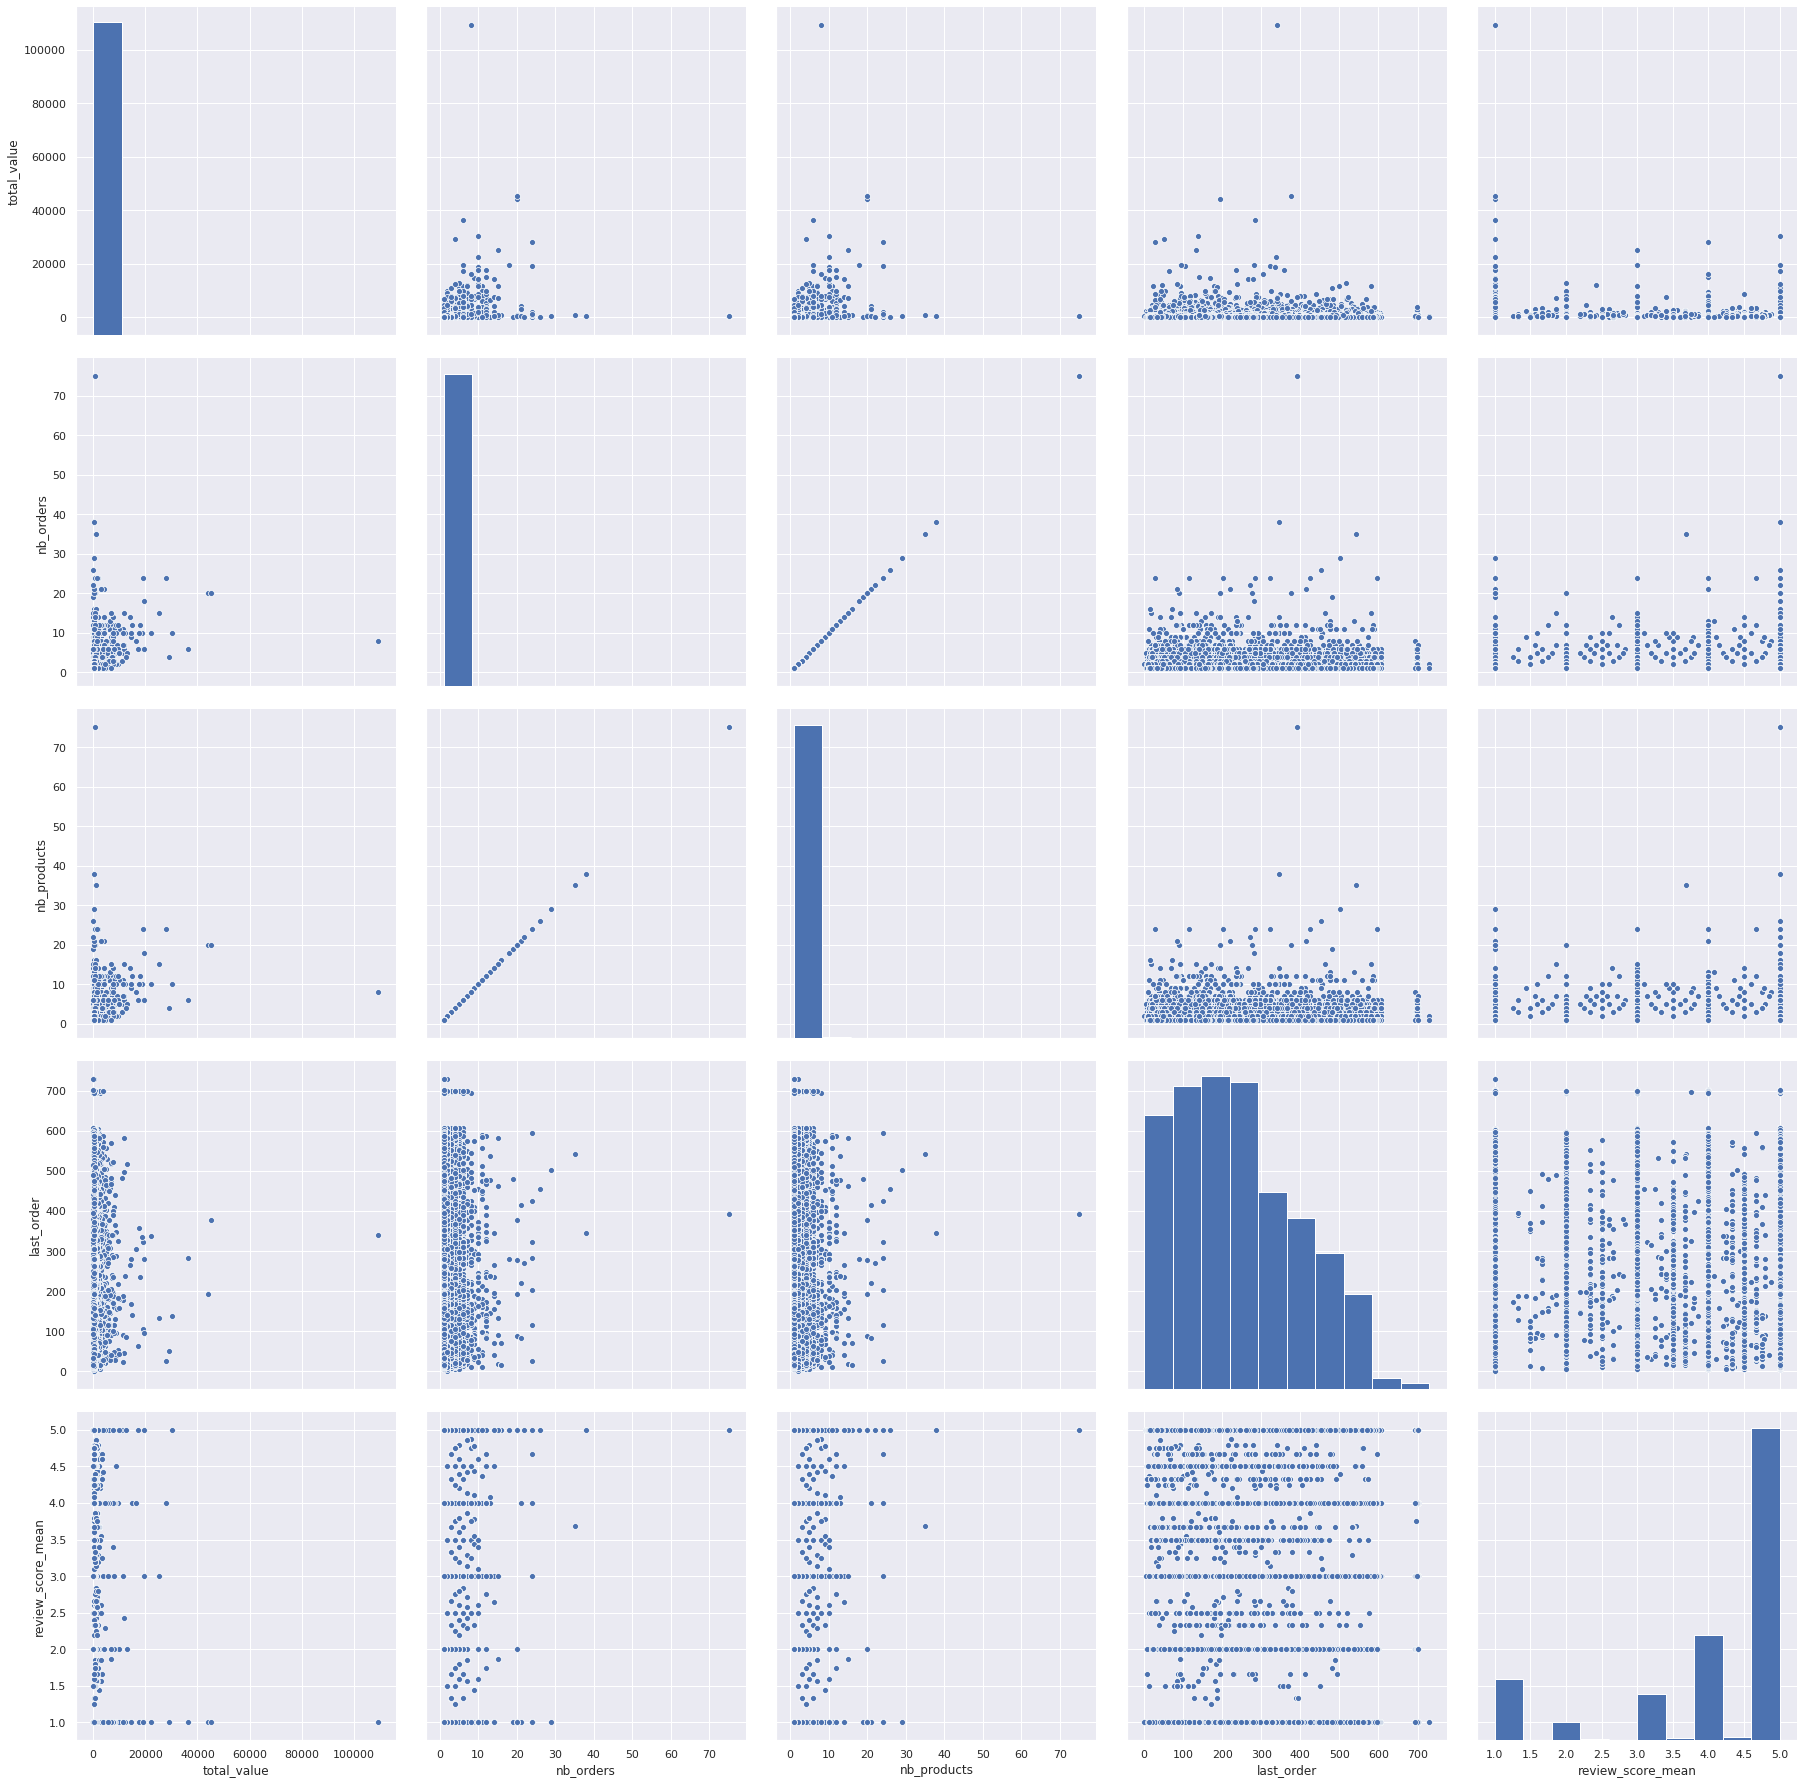

In [0]:
# Pairplot
sns.set()
sns.pairplot(data_analysis, height=5)
plt.show()


Ensuite, l'affichage d'une heatmap permet d'étudier les corrélations entre toutes nos variables. Ici, nous pouvons voir que toutes les variables sélectionnées n'ont aucune corrélation entre elles (au maximum 0.44 entre le nombre de produits et le nombre de commandes).

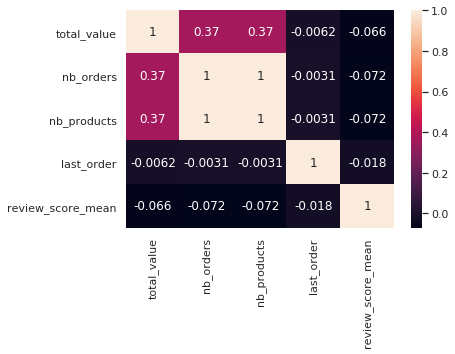

In [0]:
# Heatmap
sns.set()
fig, ax = plt.subplots()
sns.heatmap(data_analysis.corr(), annot=True)
plt.show()


Enfin, nous effectuons des histogrammes afin d'étudier de manière univariée ces mêmes variables :
- Sur le montant total des commandes, tous les clients ont dépensé entre 0 et 10000 réal brésiliens (R$).
- Sur le nombre de commandes, environ 15000 personnes ont effectué plus d'une commande, tous les autres n'en ont fait qu'une seule.
- Sur le nombre de produits, la majorité (80000) n'en a commandé qu'un seul. Moins de 15000 clients ont commandé entre 2 et 4 produits, et les rares clients restants en ont commandé plus.
- Sur la date de la dernière commande, la majorité a été effectuée durant l'année en cours.
- Sur le score moyen des notes de produits, la majorité des clients (environ 75000) sont satisfaits. Cependant, cela laisse tout de même près de 20000 clients peu ou pas satisfaits (note entre 1 et 3 sur 5)

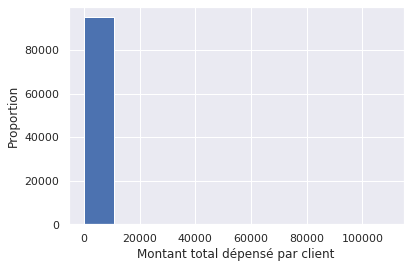

1     78492
2     11748
3      2496
4      1187
5       437
6       358
7       103
8        67
9        36
12       34
10       33
11       28
14       13
24        8
15        7
20        6
13        5
16        4
75        3
21        3
35        1
18        1
19        1
22        1
26        1
29        1
38        1
Name: nb_orders, dtype: int64


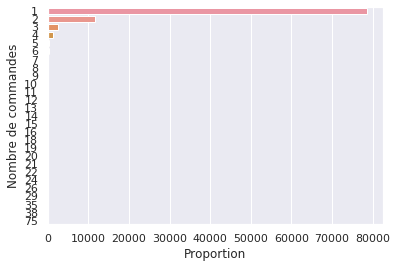

1     78492
2     11748
3      2496
4      1187
5       437
6       358
7       103
8        67
9        36
12       34
10       33
11       28
14       13
24        8
15        7
20        6
13        5
16        4
75        3
21        3
35        1
18        1
19        1
22        1
26        1
29        1
38        1
Name: nb_products, dtype: int64


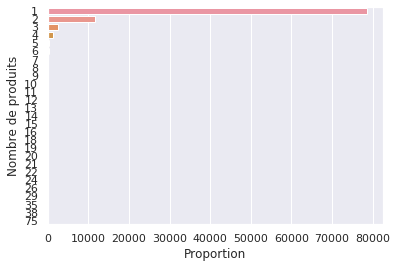

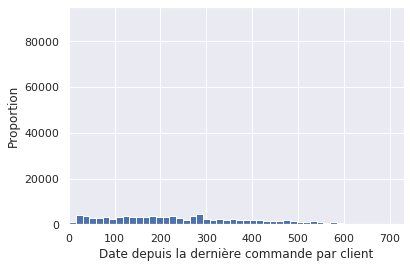

5.000000    53860
4.000000    18151
1.000000    10651
3.000000     8010
2.000000     3088
            ...  
2.250000        1
3.685714        1
3.600000        1
2.400000        1
3.555556        1
Name: review_score_mean, Length: 66, dtype: int64


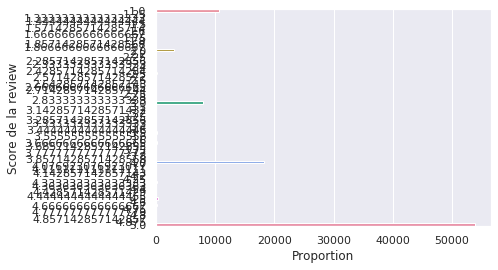

In [0]:
# Total order value distribution
sns.set()
x = data_analysis["total_value"]
plt.hist(x)

plt.xlabel('Montant total dépensé par client')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()

# Order number distribution

sns.set()
order = data_analysis['nb_orders'].value_counts()
print (order)
labels = order.index
sizes = order.values

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.ylabel('Nombre de commandes')
plt.xlabel('Proportion')
plt.show()

# Product number distribution
sns.set()
product = data_analysis['nb_products'].value_counts()
print (product)
labels = product.index
sizes = product.values

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.ylabel('Nombre de produits')
plt.xlabel('Proportion')
plt.show()

# Time period from last order distribution

sns.set()
x = data_analysis["last_order"]
plt.hist(x, bins=50)

plt.xlabel('Date depuis la dernière commande par client')
plt.ylabel('Proportion')
plt.axis([0, max(x), 0, len(x)])
plt.grid(True)
plt.show()

# Review score distribution

sns.set()
review = data_analysis['review_score_mean'].value_counts()
print (review)
labels = review.index
sizes = review.values

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.ylabel('Score de la review')
plt.xlabel('Proportion')
plt.show()
